<a href="https://colab.research.google.com/github/allthemod/people-counter/blob/main/PoepleCounter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install opencv-python
!pip install urllib3
!pip install pytube
!pip install ultralytics==8.0.196
!pip install requests

In [ ]:
!pip show ultralytics

Name: ultralytics
Version: 8.0.196
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 


In [9]:
import cv2
import urllib.request
from pytube import YouTube
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

from IPython.display import display, Image, clear_output
import requests

size = (640, 640)

In [3]:
import argparse

import cv2.dnn
import numpy as np

from ultralytics.utils import ASSETS, yaml_load
from ultralytics.utils.checks import check_yaml

CLASSES = yaml_load(check_yaml("coco128.yaml"))["names"]
colors = np.random.uniform(0, 255, size=(len(CLASSES), 3))


def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    """
    Draws bounding boxes on the input image based on the provided arguments.

    Args:
        img (numpy.ndarray): The input image to draw the bounding box on.
        class_id (int): Class ID of the detected object.
        confidence (float): Confidence score of the detected object.
        x (int): X-coordinate of the top-left corner of the bounding box.
        y (int): Y-coordinate of the top-left corner of the bounding box.
        x_plus_w (int): X-coordinate of the bottom-right corner of the bounding box.
        y_plus_h (int): Y-coordinate of the bottom-right corner of the bounding box.
    """
    label = f"{CLASSES[class_id]} ({confidence:.2f})"
    color = colors[class_id]
    cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(img, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def main(onnx_model, input_image):
    """
    Main function to load ONNX model, perform inference, draw bounding boxes, and display the output image.

    Args:
        onnx_model (str): Path to the ONNX model.
        input_image (str): Path to the input image.

    Returns:
        list: List of dictionaries containing detection information such as class_id, class_name, confidence, etc.
    """
    # Load the ONNX model
    model: cv2.dnn.Net = cv2.dnn.readNetFromONNX(onnx_model)

    # Read the input image
    original_image: np.ndarray = input_image
    [height, width, _] = original_image.shape

    # Prepare a square image for inference
    length = max((height, width))
    image = np.zeros((length, length, 3), np.uint8)
    image[0:height, 0:width] = original_image

    # Calculate scale factor
    scale = length / size[0]

    # Preprocess the image and prepare blob for model
    blob = cv2.dnn.blobFromImage(image, scalefactor=1 / 255, size=size, swapRB=True)
    model.setInput(blob)

    # Perform inference
    outputs = model.forward()

    # Prepare output array
    outputs = np.array([cv2.transpose(outputs[0])])
    rows = outputs.shape[1]

    boxes = []
    scores = []
    class_ids = []

    # Iterate through output to collect bounding boxes, confidence scores, and class IDs
    for i in range(rows):
        classes_scores = outputs[0][i][4:]
        (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
        if maxScore >= 0.25:
            box = [
                outputs[0][i][0] - (0.5 * outputs[0][i][2]),
                outputs[0][i][1] - (0.5 * outputs[0][i][3]),
                outputs[0][i][2],
                outputs[0][i][3],
            ]
            boxes.append(box)
            scores.append(maxScore)
            class_ids.append(maxClassIndex)

    # Apply NMS (Non-maximum suppression)
    result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)

    detections = []

    # Iterate through NMS results to draw bounding boxes and labels
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes[index]
        detection = {
            "class_id": class_ids[index],
            "class_name": CLASSES[class_ids[index]],
            "confidence": scores[index],
            "box": box,
            "scale": scale,
        }
        detections.append(detection)
        draw_bounding_box(
            original_image,
            class_ids[index],
            scores[index],
            round(box[0] * scale),
            round(box[1] * scale),
            round((box[0] + box[2]) * scale),
            round((box[1] + box[3]) * scale),
        )

    # Display the image with bounding boxes
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return detections

In [13]:
model = YOLO("yolov8m.pt")
model.export(format="onnx", imgsz=list(size))
def Download(link):
    youtubeObject = YouTube(link)
    youtubeObject = youtubeObject.streams.get_highest_resolution()
    try:
        youtubeObject.download(filename="video.mp4")
    except:
        print("An error has occurred")
    print("Download is completed successfully")
def download_mp4(url):
    destination = "video.mp4"
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Download successful. Saved to {destination}")
    else:
        print(f"Failed to download. Status code: {response.status_code}")

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from 'yolov8m.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: export success ✅ 4.2s, saved as 'yolov8m.onnx' (99.0 MB)

Export complete (9.9s)
Results saved to /content
Predict:         yolo predict task=detect model=yolov8m.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8m.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


In [ ]:
# prompt: load a youtube by a url to open cv

#https://www.freecodecamp.org/news/python-program-to-download-youtube-videos/

url = 'https://www.youtube.com/watch?v=dQw4w9WgXcQ'



Download(url)

In [16]:
url = "https://download1584.mediafire.com/w0w9p92zrp5gkbLoIplGNYcrMLsVDFhrc4jkbM7_1GC8-5y8RRaDB_yY8nOyuUB24ZuHLz3Eu9LWtbh_TicrDpTbGKki89yrMUJJsuEcCgk_nrbTbokN1xPqPe7CGtVUqnJux4c7xB690NZm0Pd7_ynTaHwriHiw7cp826KHqNYcjA/8k10xgbx6t04wsa/example_01.mp4"

download_mp4(url)

Download successful. Saved to video.mp4


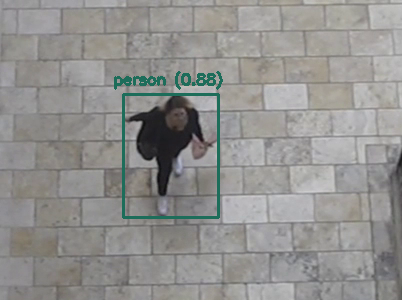

(300, 402, 3)


In [ ]:


cap = cv2.VideoCapture('video.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if ret:

        print(ret)
        #frame = cv2.resize(frame, size)
        main("yolov8m.onnx",frame)
        clear_output(wait=True)
        cv2_imshow(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()
